<a href="https://colab.research.google.com/github/arminarj/DGCCA-pytorch/blob/master/DGCCA_loss_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
a=0

In [57]:
def GCCA_loss(H_list):
    X=torch.stack(H_list).reshape(3,-1)
    S = torch.cov(X)
    corr = torch.sum(S)
    loss = - corr
    return loss

In [58]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size):
        super(MlpNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.Sigmoid(), 
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                    
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.ReLU(),
                    # nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=True),
                ))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
class DeepGCCA(nn.Module):
    def __init__(self, layer_sizes1, layer_sizes2, input_size1, input_size2, outdim_size, use_all_singular_values, device=torch.device('cpu')):
        super(DeepGCCA, self).__init__()
        self.model1 = MlpNet(layer_sizes1, input_size1).double()
        self.model2 = MlpNet(layer_sizes2, input_size2).double()
        self.model3 = MlpNet(layer_sizes2, input_size2).double()

    def forward(self, x1, x2, x3):
        """

        x1, x2 are the vectors needs to be make correlated
        dim=[batch_size, feats]

        """
        # feature * batch_size
        output1 = self.model1(x1)
        output2 = self.model2(x2)
        output3 = self.model3(x3)

        return output1, output2, output3


In [59]:
def create_synthData_new(N=400, outDir='./', device='cpu',mode=1,F=20):
    '''
    creating Main paper Synth data,
    N : number of data
    F$ : number of features in view $ 
    '''
    views  = []
    F1 = F
    F2 = F  
    F3 = F

    V1 = np.random.randn(N, F1)
    V2 = np.random.randn(N, F2)
    V3 = np.random.randn(N, F3)
    views.append(V1)
    if mode==1:
        V2[:,0]=V1[:,0]+V1[:,1]-V2[:,1]
        V3[:,0]=V1[:,0]+2*V1[:,1]-V3[:,1]
        
    if mode==2:
        V2[:,0]=np.sin(V1[:,0]+V1[:,1])-V2[:,1]
        V3[:,0]=np.sin(V2[:,0]+V2[:,1])-V3[:,1]
        
    if mode==3:
        V2[:,0]=1/(V1[:,0]+V1[:,1])-V2[:,1]
        V3[:,0]=1/(V1[:,0]+V1[:,1])-V3[:,1]

    views.append(V2) 
    views.append(V3)

    views = [torch.tensor(view).to(device) for view in views]
    return views

In [60]:
lr = 1e-2
device = 'cpu'
torch.manual_seed(1)

# size of the input for view 1 and view 2
F=10
input_shape1 = F
input_shape2 = F
input_shape3 = F
X=create_synthData_new(mode=2,F=F)
X1 = X[0]
X2 = X[1]
X3 = X[2]


outdim_size = 1

# number of layers with nodes in each one
layer_sizes1 = [128, 128, outdim_size]
layer_sizes2 = [128, 128, outdim_size]
layer_sizes3 = [128, 128, outdim_size]


tensor(-3.7924, dtype=torch.float64)

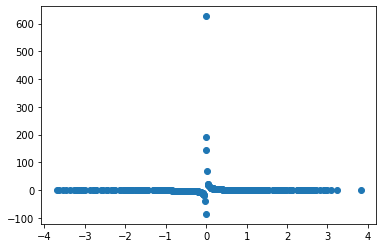

In [65]:
import matplotlib.pyplot as plt
X=create_synthData_new(400,mode=3,F=10)
X1 = X[0]
X2 = X[1]
X3 = X[2]
x = X1[:,0]+X1[:,1]
y = X2[:,0]+X2[:,1]
plt.scatter(x,y)
X1.min()

In [62]:
from copy import deepcopy as copy

model = DeepGCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, False, device).double().to(device)
lr  = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
criterion = GCCA_loss

train_loss = []

model.train()

for epoch in range(400):
    optimizer.zero_grad()
    out1, out2, out3 = model(X1, X2, X3)
    loss = criterion([out1, out2, out3])
    # print(loss)
    train_loss.append(copy(loss.data))
    loss.backward()
    optimizer.step()
    scheduler.step()


In [63]:
loss

tensor(-8.6357, dtype=torch.float64, grad_fn=<NegBackward0>)

In [70]:
H_list =[out1, out2, out3]
a=torch.stack([out1, out2, out3]).reshape(3,-1)
b = torch.cov(a)

for i in range(len(b)):
    for j in range(len(b[i])):
        b[i][j] /= torch.std(H_list[i])*torch.std(H_list[j])
b

tensor([[1.0000, 0.9784, 0.9782],
        [0.9784, 1.0000, 0.9995],
        [0.9782, 0.9995, 1.0000]], dtype=torch.float64,
       grad_fn=<AsStridedBackward0>)

In [38]:
torch.stack([out1, out2, out3]).reshape(3,400)

tensor([[-0.6814, -2.0779, -1.5268],
        [-0.1326,  0.5697,  0.5753],
        [ 0.8703,  2.0552,  0.3729],
        ...,
        [ 0.1502,  0.8841, -1.1338],
        [ 0.1226, -0.9440,  2.2582],
        [ 0.6393, -1.5740,  0.3744]], dtype=torch.float64,
       grad_fn=<ReshapeAliasBackward0>)

In [ ]:
import pandas as pd

loss_plt = pd.DataFrame(train_loss)
loss_plt.plot()

In [ ]:
criterion([X1, X2, X3])

In [ ]:
print(criterion([X1, X1, X1]))
print(criterion([X2, X2, X2]))
print(criterion([X3, X3, X3]))

In [ ]:
out1.shape

In [ ]:
out